In [1]:
!pip install wfdb matplotlib numpy scipy

Libraries

In [2]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

Load ECG Data

Loaded record '100' with sampling rate 360 Hz


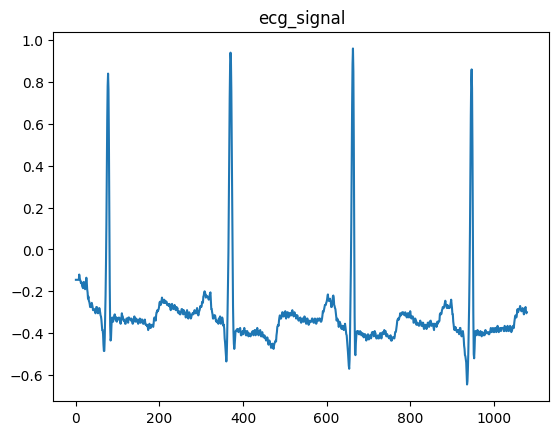

In [25]:
record_name = '100'  # Replace with your .dat file name (without extension)
   
    # Read the .dat file using wfdb
try:
    record = wfdb.rdrecord(record_name)
    ecg_signal = record.p_signal[:, 0]
    fs = record.fs  # Sampling frequency (Hz)
    
    samp_sec = 3  # Number of seconds to plot
    # num_samples = int(120 * fs)  # Number of samples in 120 seconds
    num_samples = int(samp_sec * fs)
    ecg_signal = ecg_signal[:num_samples]
    print(f"Loaded record '{record_name}' with sampling rate {fs} Hz")
except FileNotFoundError:
    print(f"Error: Record '{record_name}' not found. Check PhysioNet access.")
    
plt.plot(ecg_signal)
plt.title("ecg_signal")
plt.show()
    

Amplitude Normalization

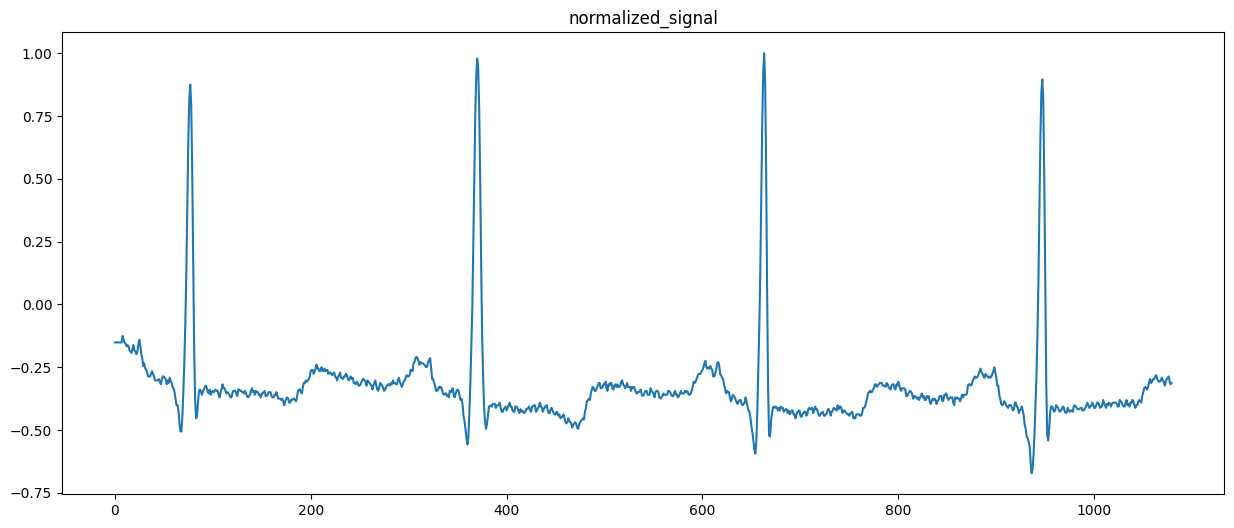

In [41]:
def amplitude_normalization(signal):
    return signal / np.max(np.abs(signal))

normalized_signal = amplitude_normalization(ecg_signal)
plt.figure(figsize=(15, 6))
plt.plot(normalized_signal)
plt.title("normalized_signal")
plt.show()

Bandpass Filtering (0.5–40 Hz)

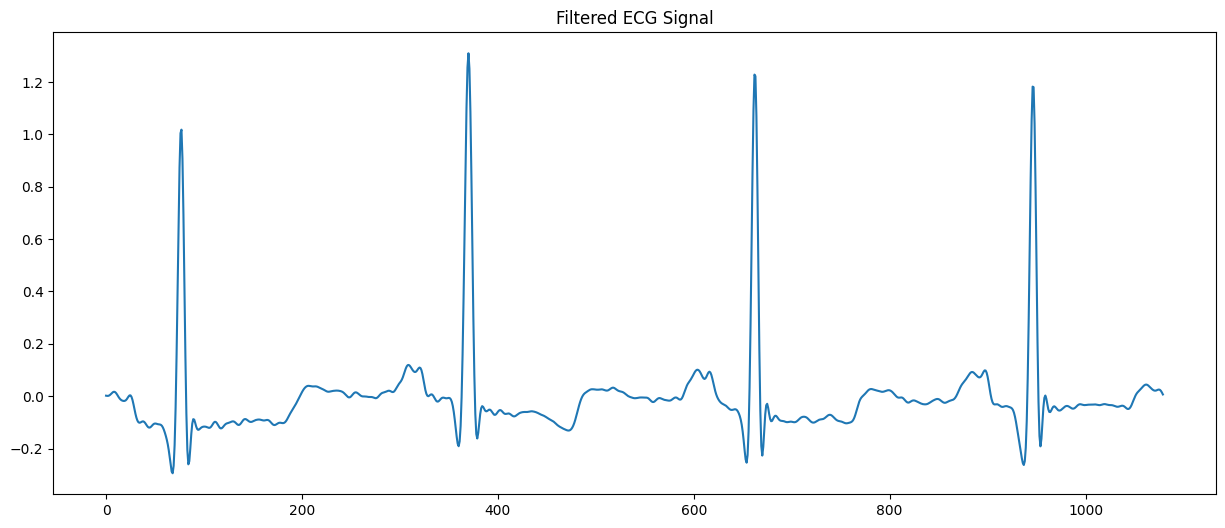

In [40]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

filtered_signal = butter_bandpass_filter(normalized_signal, 0.5, 40, fs)
plt.figure(figsize=(15, 6))
plt.plot(filtered_signal)
plt.title("Filtered ECG Signal")
plt.show()

 Feature Extraction

Detected 4 R-peaks


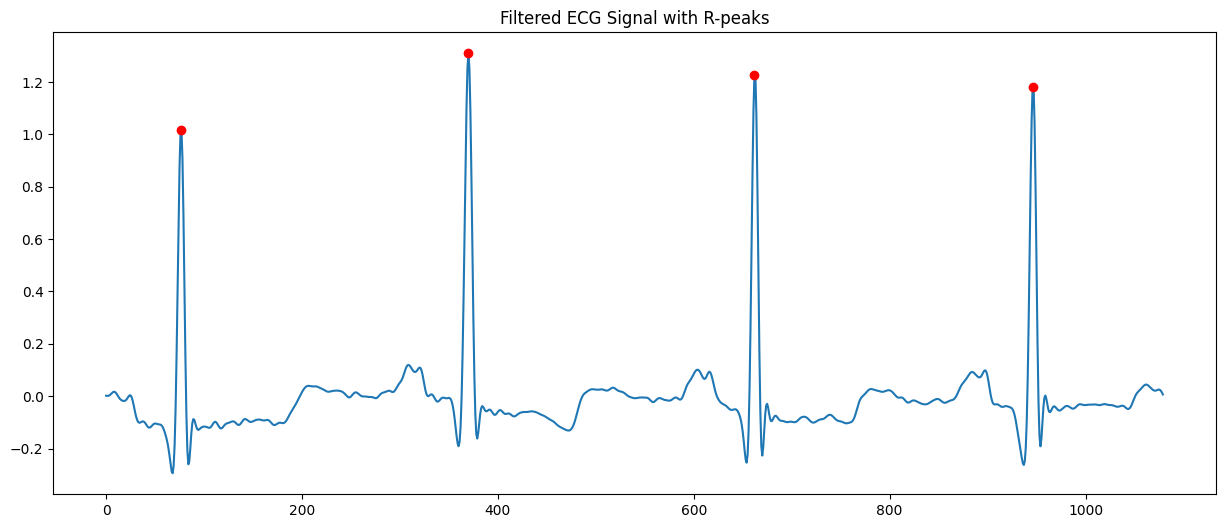

In [39]:
def detect_r_peaks(signal, fs):
    peaks, _ = find_peaks(signal, height=np.mean(signal), distance=fs*0.6)
    return peaks

r_peaks = detect_r_peaks(filtered_signal, fs)
print(f"Detected {len(r_peaks)} R-peaks")
plt.figure(figsize=(15, 6))
plt.plot(filtered_signal)
plt.plot(r_peaks, filtered_signal[r_peaks], 'ro')
plt.title("Filtered ECG Signal with R-peaks")
plt.show()


QRS Complex Detection (Pan-Tompkins)

Detected 22 QRS peaks


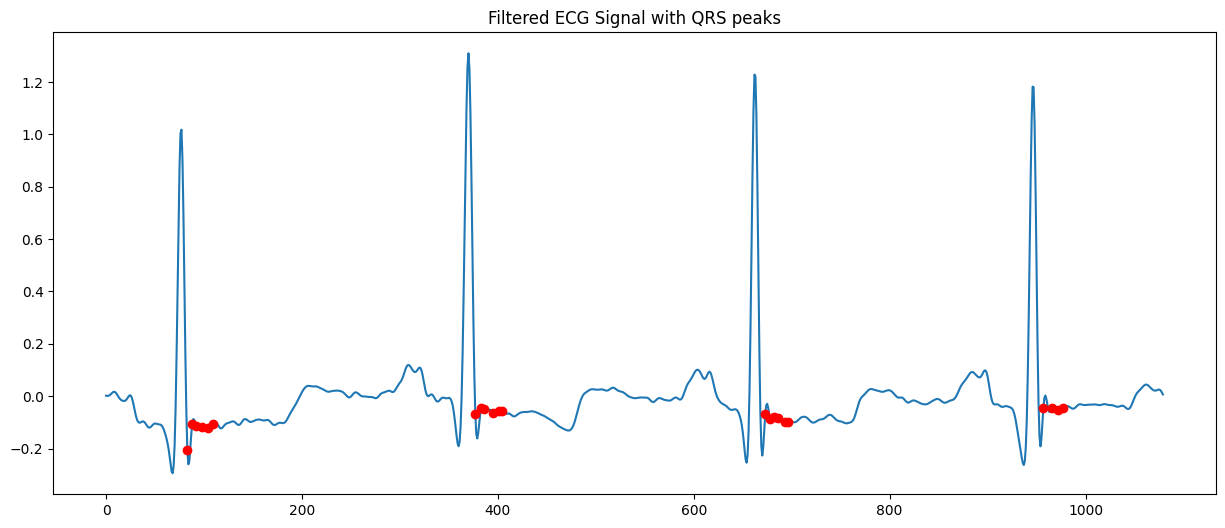

In [38]:
def pan_tompkins_qrs_detection(signal, fs):
    # Bandpass filter (already done in preprocessing)
    diff_signal = np.diff(signal)
    squared_signal = diff_signal ** 2
    window_size = int(0.15 * fs)
    integrated_signal = np.convolve(squared_signal, np.ones(window_size)/window_size)
    threshold = 0.5 * np.max(integrated_signal)
    qrs_peaks, _ = find_peaks(integrated_signal, height=threshold)
    return qrs_peaks

qrs_peaks = pan_tompkins_qrs_detection(filtered_signal, fs)
print(f"Detected {len(qrs_peaks)} QRS peaks")
plt.figure(figsize=(15, 6))
plt.plot(filtered_signal)   
plt.plot(qrs_peaks, filtered_signal[qrs_peaks], 'ro')
plt.title("Filtered ECG Signal with QRS peaks")
plt.show()

Detect Q, S, P, T Peaks

Detected 4 Q-peaks and 4 S-peaks
Detected 4 P-peaks and 4 T-peaks


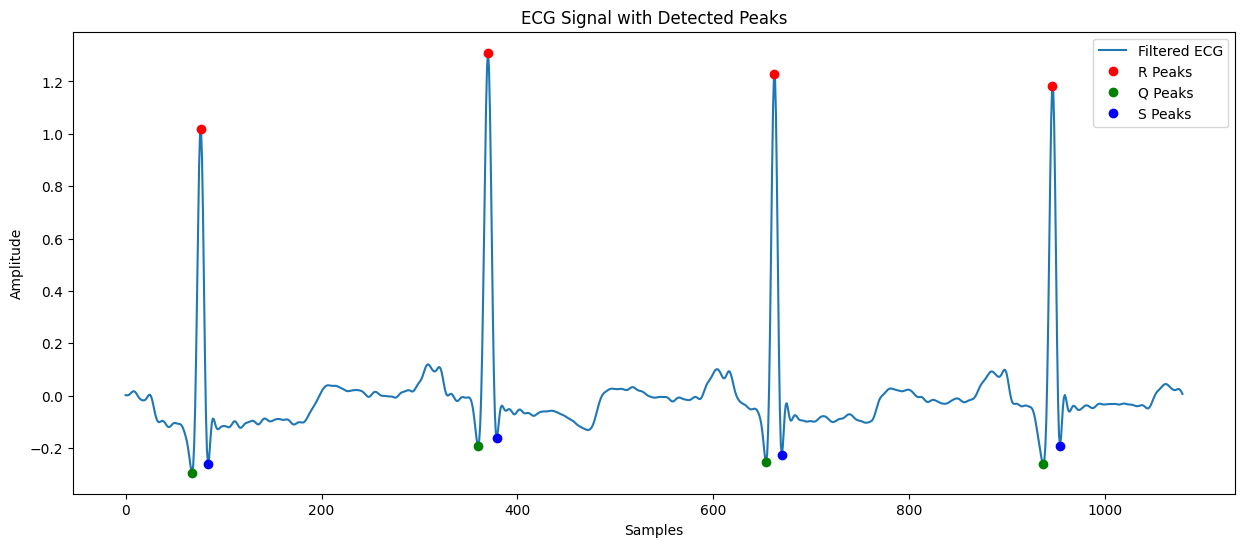

In [37]:
def detect_qs_peaks(signal, r_peaks):
    q_peaks, s_peaks = [], []
    for r in r_peaks:
        q_window = signal[max(0, r-50):r]
        q_peaks.append(np.argmin(q_window) + max(0, r-50))
        s_window = signal[r:min(len(signal), r+50)]
        s_peaks.append(np.argmin(s_window) + r)
    return np.array(q_peaks), np.array(s_peaks)

def detect_pt_peaks(signal, r_peaks, fs):
    p_peaks, t_peaks = [], []
    for r in r_peaks:
        p_window = signal[max(0, r - int(0.2*fs)):r]
        p_peaks.append(np.argmax(p_window) + max(0, r - int(0.2*fs)))
        t_window = signal[r:min(len(signal), r + int(0.4*fs))]
        t_peaks.append(np.argmax(t_window) + r)
    return np.array(p_peaks), np.array(t_peaks)

q_peaks, s_peaks = detect_qs_peaks(filtered_signal, r_peaks)
p_peaks, t_peaks = detect_pt_peaks(filtered_signal, r_peaks, fs)
print(f"Detected {len(q_peaks)} Q-peaks and {len(s_peaks)} S-peaks")
print(f"Detected {len(p_peaks)} P-peaks and {len(t_peaks)} T-peaks")    
plt.figure(figsize=(15, 6))
plt.plot(filtered_signal, label='Filtered ECG')
plt.plot(r_peaks, filtered_signal[r_peaks], 'ro', label='R Peaks')
plt.plot(q_peaks, filtered_signal[q_peaks], 'go', label='Q Peaks')
plt.plot(s_peaks, filtered_signal[s_peaks], 'bo', label='S Peaks')
# plt.plot(p_peaks, filtered_signal[p_peaks], 'yo', label='P Peaks')
# plt.plot(t_peaks, filtered_signal[t_peaks], 'mo', label='T Peaks')
plt.title('ECG Signal with Detected Peaks')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

Calculate Dynamic Features

In [32]:
rr_intervals = np.diff(r_peaks) / fs  # In seconds
heart_rate = 60 / np.mean(rr_intervals)
hrv = (np.max(rr_intervals) - np.min(rr_intervals)) * 100
print(f"Heart rate: {heart_rate:.2f} bpm")
print(f"HRV: {hrv:.2f} ms")

Heart rate: 74.57 bpm
HRV: 2.50 ms


R/P Ratio

In [33]:
r_amplitudes = filtered_signal[r_peaks]
p_amplitudes = filtered_signal[p_peaks]
r_to_p_ratio = np.mean(r_amplitudes / p_amplitudes)
print(f"R-to-P amplitude ratio: {r_to_p_ratio:.2f}")


R-to-P amplitude ratio: 1.08


Rule-Based Classification

In [45]:
classification = []

# Rule-based checks
if heart_rate < 60:
    classification.append("Bradycardia")
elif heart_rate > 100:
    classification.append("Tachycardia")

# Check for irregular RR intervals (AFib)
rr_std = np.std(rr_intervals)
if rr_std > 0.15 and len(p_peaks) < 0.5 * len(r_peaks):  # Arbitrary thresholds
    classification.append("Atrial Fibrillation (Suspected)")

# If no conditions met, classify as Normal
if not classification:
    classification.append("Normal - healthy")

# Print results
print("Classification Results:", ", ".join(classification))

Classification Results: Normal - healthy


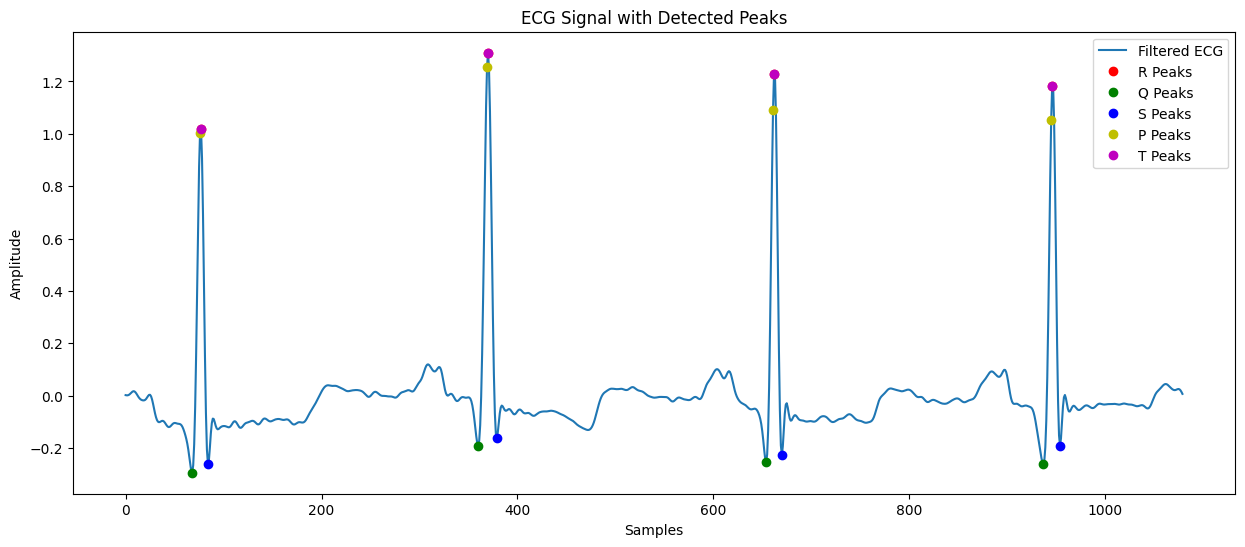

In [35]:
plt.figure(figsize=(15, 6))
plt.plot(filtered_signal, label='Filtered ECG')
plt.plot(r_peaks, filtered_signal[r_peaks], 'ro', label='R Peaks')
plt.plot(q_peaks, filtered_signal[q_peaks], 'go', label='Q Peaks')
plt.plot(s_peaks, filtered_signal[s_peaks], 'bo', label='S Peaks')
plt.plot(p_peaks, filtered_signal[p_peaks], 'yo', label='P Peaks')
plt.plot(t_peaks, filtered_signal[t_peaks], 'mo', label='T Peaks')
plt.title('ECG Signal with Detected Peaks')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

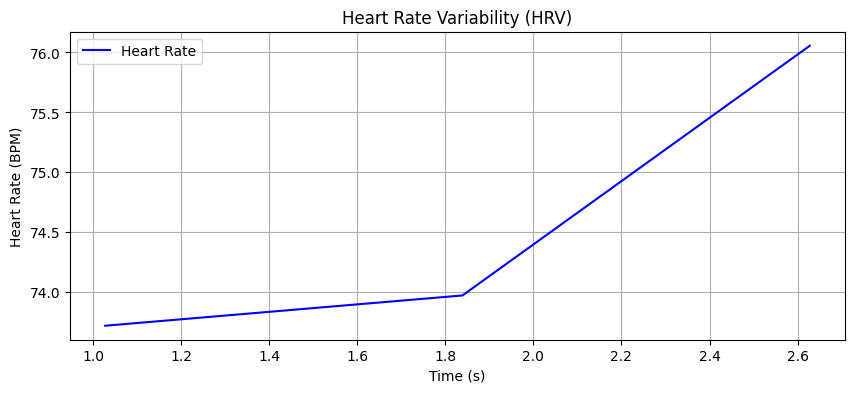

In [43]:
plt.figure(figsize=(10, 4))
plt.plot(r_peaks[1:]/fs, 60/rr_intervals, 'b-')
plt.xlabel('Time (s)')
plt.ylabel('Heart Rate (BPM)')
plt.legend(['Heart Rate'])
plt.title('Heart Rate Variability (HRV)')
plt.grid(True)
plt.show()